# Basic pipeline

**Noam Gini 208375642  
Shai Fisher 315150342**

## Flight fares predictions using the following dataset: [Filght fares](https://www.kaggle.com/datasets/yashdharme36/airfare-ml-predicting-flight-fares)

### Imports of relevant packages

In [420]:
#data processing
import pandas as pd
import numpy as np

#data visualizations
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#Machine learning library
import sklearn

## Introducing the Flight fares dataset - Exploratory Data Analysis (EDA)

In [421]:
dtf = pd.read_csv("./data/data_airfare.csv")

In [422]:
numeric_columns = dtf.dtypes[(dtf.dtypes=="float64") | (dtf.dtypes=="int64")].index.tolist()
categorical_columns = [c for c in dtf.columns if c not in numeric_columns]

In [423]:
cols = ["Date_of_journey","Journey_day","Airline","Flight_code","Class",
        "Source","Departure","Total_stops","Arrival","Destination",
        "Duration_in_hours", "Days_left", "Fare"]
dtf = dtf[cols]

**Let's take a look at the data**

In [424]:
dtf.head()

,Date_of_journey,Journey_day,Airline,Flight_code,Class,Source,Departure,Total_stops,Arrival,Destination,Duration_in_hours,Days_left,Fare
0,2023-01-16,Monday,SpiceJet,SG-8169,Economy,Delhi,After 6 PM,non-stop,After 6 PM,Mumbai,2.0833,1,5335
1,2023-01-16,Monday,Indigo,6E-2519,Economy,Delhi,After 6 PM,non-stop,Before 6 AM,Mumbai,2.3333,1,5899
2,2023-01-16,Monday,GO FIRST,G8-354,Economy,Delhi,After 6 PM,non-stop,Before 6 AM,Mumbai,2.1667,1,5801
3,2023-01-16,Monday,SpiceJet,SG-8709,Economy,Delhi,After 6 PM,non-stop,After 6 PM,Mumbai,2.0833,1,5794
4,2023-01-16,Monday,Air India,AI-805,Economy,Delhi,After 6 PM,non-stop,After 6 PM,Mumbai,2.1667,1,5955


In [425]:
dtf.describe()

,Duration_in_hours,Days_left,Fare
count,452088.000000,452088.000000,452088.000000
mean,12.349222,25.627902,22840.100890
std,7.431478,14.300846,20307.963002
min,0.750000,1.000000,1307.000000
25%,6.583300,13.000000,8762.750000
50%,11.333300,26.000000,13407.000000
75%,16.500000,38.000000,35587.000000
max,43.583300,50.000000,143019.000000


**Note:** The Fare of the flight tickets is in INR  
**1 USD = 82.78 INR**

**Examining the target feature - "Fare" Using Histogram, a KDE plot, and a Box plot**

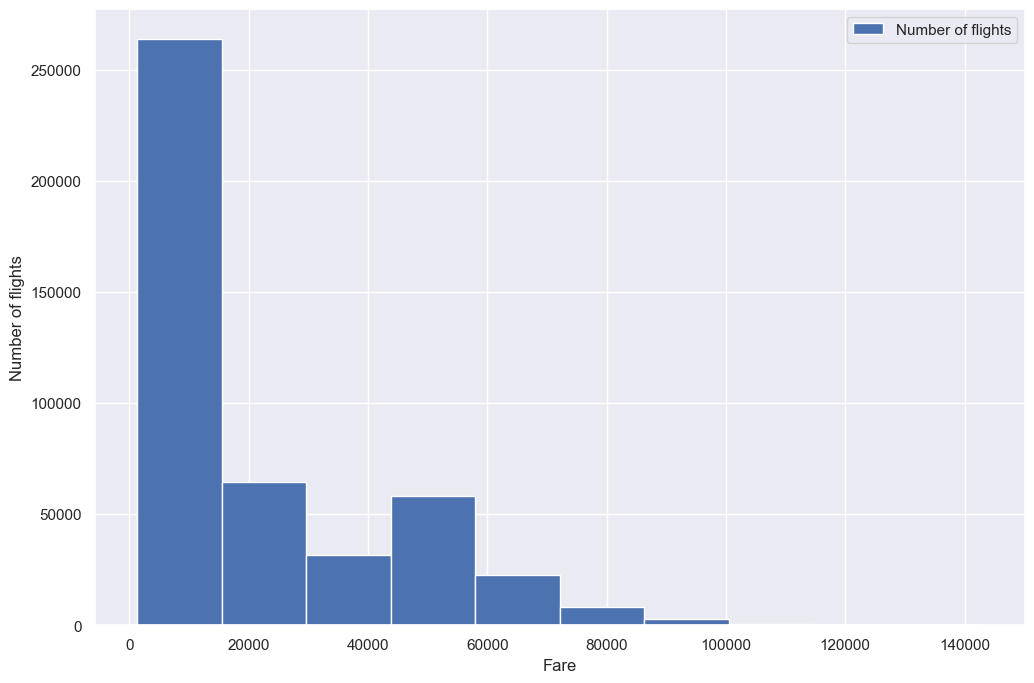

In [426]:
dtf.Fare.hist(label = 'Number of flights')

# Add labels to the x and y axes
plt.xlabel('Fare')
plt.ylabel('Number of flights')

# Add legend
plt.legend()

# Show the plot
plt.show()



Exploring the tickets fare:
From the description table above the histogram, we learn that the minimum ticket fare is 1,307 INR and maximum is 143,019 INR. There exists a difference in mean and median values as well.  
Now let's visualize the fare column using a kde plot and a box plot.

<Axes: xlabel='Fare', ylabel='Density'>

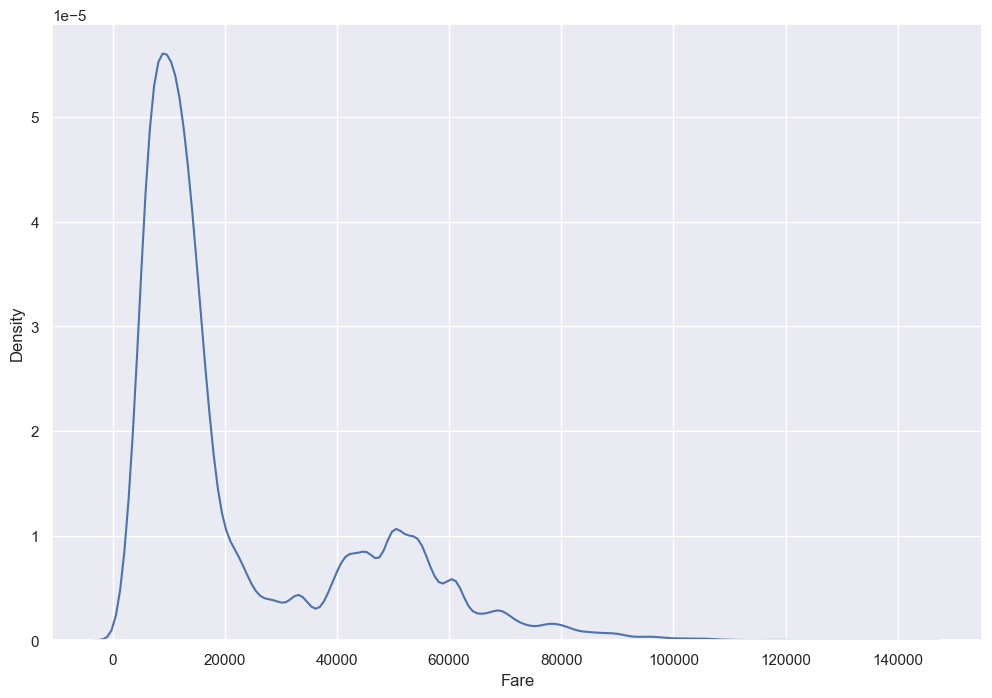

In [427]:
sns.kdeplot(dtf.Fare)

We can see that the data may contains outliers.

Let's examine the outliers

<Axes: xlabel='Fare'>

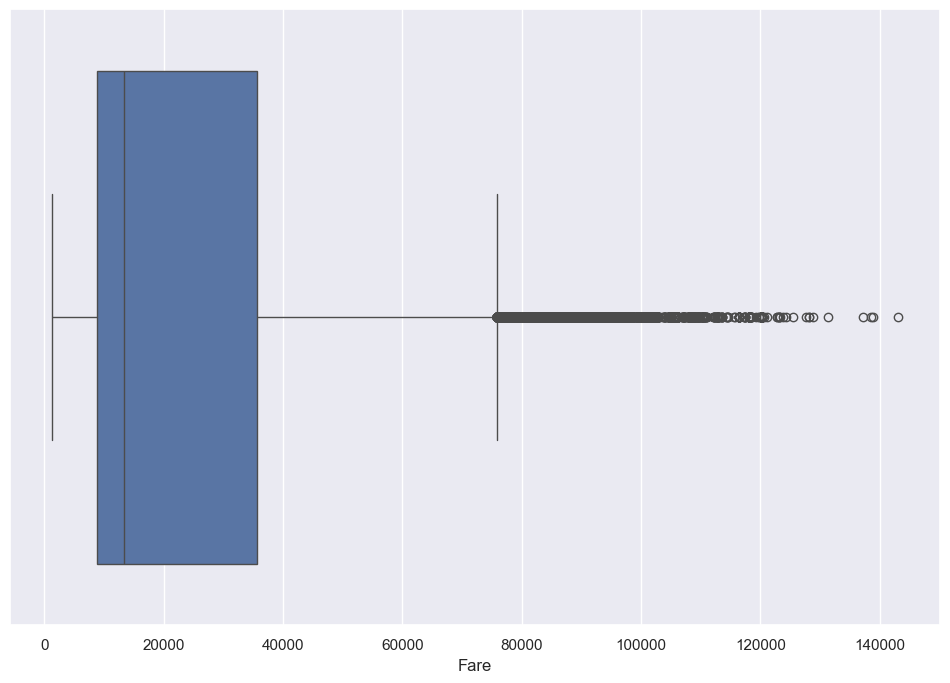

In [428]:
sns.boxplot(dtf.Fare, orient="h")

A Fare outlier is acceptable because there are different ticket classes - Economy, Premium Economy, Business and First class.
Even though the mean is around 20000, we can see that the median is approximately 14000.
In the KDE plot, we can see that the dispersion seems to be composed by two gaussian curves.
The first one - From 1,000 to 30,000 there is one peak, corresponding to the cheap tickets 
The second one - A peak from 40,000 to 80,000 corresponding to the expensive classes tickets.
We have decided not to remove the fare outliers for now.

## Cleaning and Preprocessing

We will make sure that there are no null values in our data

In [429]:
dtf.isnull().sum()

Date_of_journey      0
Journey_day          0
Airline              0
Flight_code          0
Class                0
Source               0
Departure            0
Total_stops          0
Arrival              0
Destination          0
Duration_in_hours    0
Days_left            0
Fare                 0
dtype: int64

There are no missing values in our dataset.

Now we will check for duplicates in our data

In [430]:
dtf.duplicated().sum()

6722

There are 6722 duplicated rows, So let's remove them.

In [431]:
dtf = dtf.drop_duplicates()

In [432]:
#check that the duplicates are gone
dtf.duplicated().sum()

0

We will change the 'Days_left' to a more indicitive name

In [433]:
# Change the column  from 'Days_left' to 'Advance_purchase_days' for clearity
dtf.rename(columns={'Days_left': 'Advance_days'}, inplace=True)

We will check the format and uniqueness of the 'Arrival' and 'Departure' values

In [434]:
dtf['Departure'].unique()

array(['After 6 PM', 'Before 6 AM', '12 PM - 6 PM', '6 AM - 12 PM'],
      dtype=object)

In [435]:
dtf['Arrival'].unique()

array(['After 6 PM', 'Before 6 AM', '6 AM - 12 PM', '12 PM - 6 PM'],
      dtype=object)

We will change the naming conventions for the 'Arrival' and 'Departure' fields

In [436]:
# Function to map departure time ranges to categories
def map_departure_time_range(departure_time):
    if 'Before 6 AM' in departure_time:
        return 'Early morning'
    elif '6 AM - 12 PM' in departure_time:
        return 'morning'
    elif '12 PM - 6 PM' in departure_time:
        return 'noon'
    else:
        return 'night'

# Apply the function to the columns
dtf['Departure'] = dtf['Departure'].apply(map_departure_time_range)
dtf['Arrival'] = dtf['Arrival'].apply(map_departure_time_range)

dtf.head()

,Date_of_journey,Journey_day,Airline,Flight_code,Class,Source,Departure,Total_stops,Arrival,Destination,Duration_in_hours,Advance_days,Fare
0,2023-01-16,Monday,SpiceJet,SG-8169,Economy,Delhi,night,non-stop,night,Mumbai,2.0833,1,5335
1,2023-01-16,Monday,Indigo,6E-2519,Economy,Delhi,night,non-stop,Early morning,Mumbai,2.3333,1,5899
2,2023-01-16,Monday,GO FIRST,G8-354,Economy,Delhi,night,non-stop,Early morning,Mumbai,2.1667,1,5801
3,2023-01-16,Monday,SpiceJet,SG-8709,Economy,Delhi,night,non-stop,night,Mumbai,2.0833,1,5794
4,2023-01-16,Monday,Air India,AI-805,Economy,Delhi,night,non-stop,night,Mumbai,2.1667,1,5955


We will examine the data related to dates

In [437]:
# Convert the "Date_of_journey" column to datetime format
dtf['Date_of_journey'] = pd.to_datetime(dtf['Date_of_journey'])

# Extract the month from the dates
dtf['Month'] = dtf['Date_of_journey'].dt.month

# Group the flights by month and count the number of flights in each month
dtf.groupby('Month').size()

Month
1    140370
2    251603
3     53393
dtype: int64

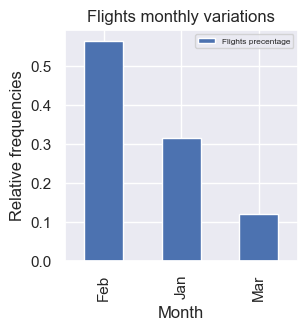

In [438]:
Month_ = pd.to_datetime(dtf.Date_of_journey.values).month
pd.Series(Month_.value_counts(normalize = True).values,index=["Feb","Jan","Mar"]).\
    plot(kind = 'bar', title="Flights monthly variations",  figsize=[3, 3], xlabel = "Month", ylabel = "Relative frequencies", label = "Flights precentage")
plt.legend(prop={'size': 6})
plt.show()

We can see that Feburary is a busy month in flights, this might be because February often marks the end of winter and the beginning of spring in many parts of India. This transition period might witness increased travel activities due to favorable weather conditions, leading to more flights.
 

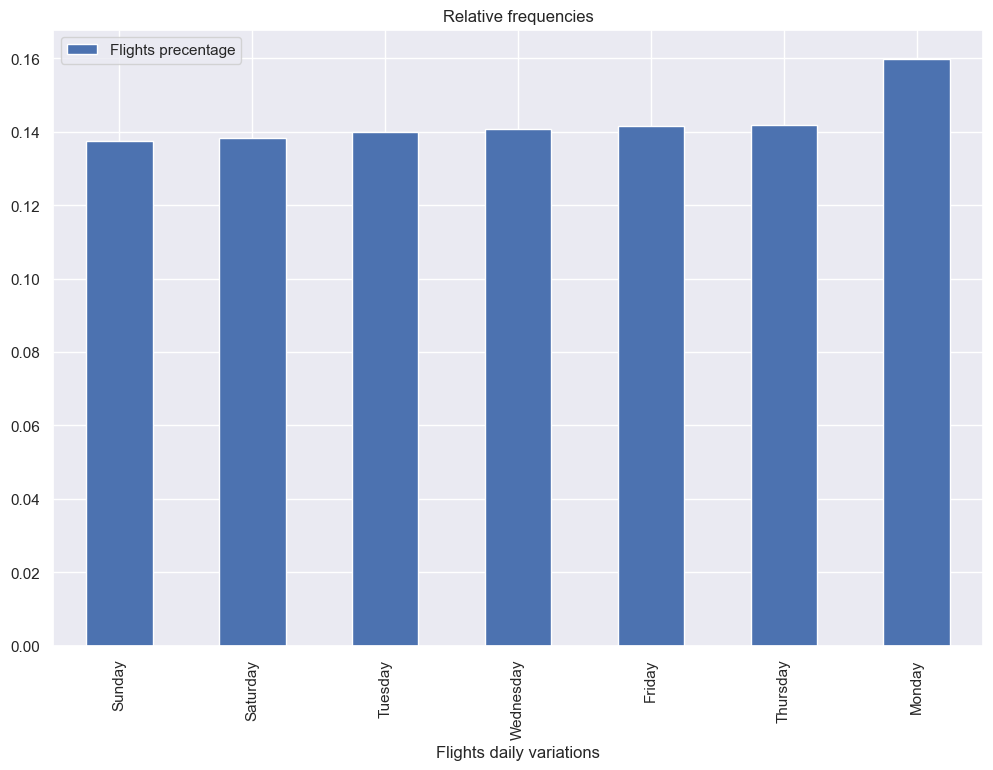

In [439]:
dtf.Journey_day.value_counts(normalize = True, ascending = True).plot(kind="bar",
 title = "Relative frequencies",xlabel = "Flights daily variations", label = "Flights precentage")
plt.legend()


We can see that the precentage of the flights is pretty similar for all the days, except Monday.
we would expect that there will be a significant difference between the number of flights during the weekend and the weekdays.

To ensure that our training and test sets accurately represent the daily variations observed in the dataset, where flights are evenly distributed across all seven weekdays, we will employ a stratified split based on this feature during the data partitioning process. This approach will help maintain the proportional representation of each weekday's frequencies in both the training and test sets.

### Visualization

Now we will take a look at the Histogram for each categorical attribute

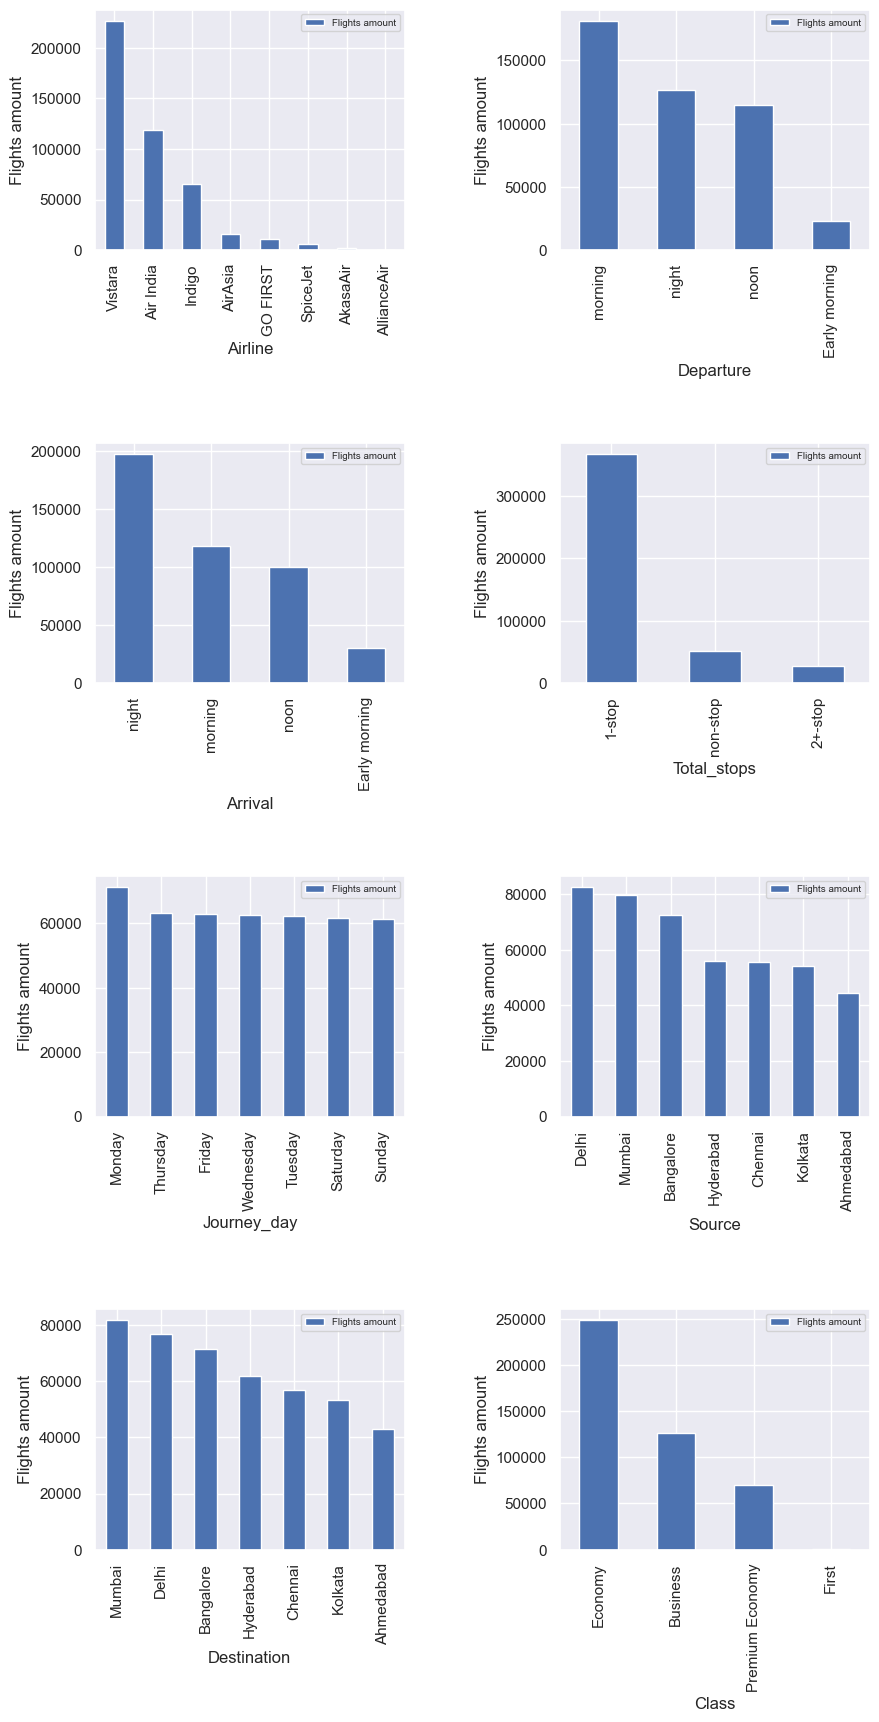

In [440]:

# Define the names of categorical columns to remove
columns_to_remove = ["Date_of_journey", "Flight_code"]

# Define the desired order of categorical columns
desired_order = ["Airline", "Departure", "Arrival", "Total_stops", "Journey_day", "Source", "Destination", "Class"]

# Filter categorical columns based on the condition and desired order
categorical_columns_filtered = [c for c in desired_order if c not in columns_to_remove]
                                
n = len(categorical_columns_filtered)
cols = 2
max_bars = 8

rows = (n // cols) + (1 if n % cols != 0 else 0)

#generate a figures grid
fig, axes = plt.subplots(rows,cols,figsize=(cols*5,rows*5))
fig.subplots_adjust(hspace=0.8, wspace=0.5)

for i,column in enumerate(categorical_columns_filtered):
    #calculate the current place on the grid
    r=int(i/cols)
    c=i%cols
    
    #create the "value counts" for the first <max_bars> categories
    u=min(dtf[column].nunique(),max_bars)
    vc = dtf[column].value_counts()[:u]
    
    # plot a bar chart using Pandas
    vc.plot(kind='bar',ax=axes[r,c], xlabel = column, ylabel = "Flights amount", label="Flights amount")
    axes[r, c].legend(prop={'size':7})



And now for the numeric attributes

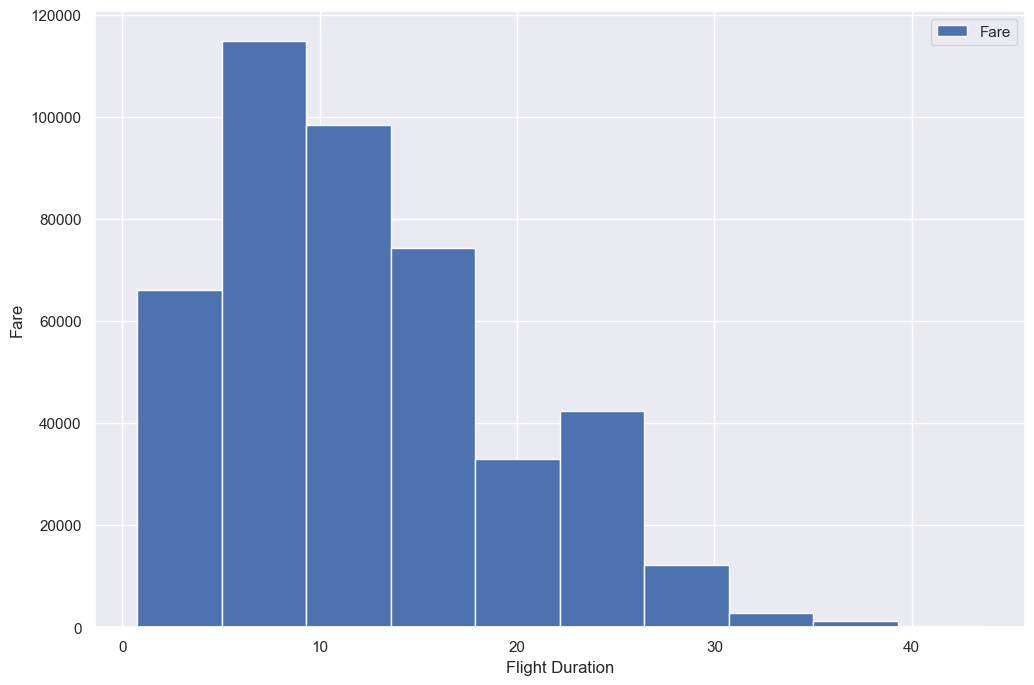

In [441]:
dtf.Duration_in_hours.hist(label = "Fare")

# Add labels to the x and y axes
plt.xlabel('Flight Duration')
plt.ylabel('Fare')
plt.legend()

# Show the plot
plt.show()

We can see that most expensive flights are around 10 hours.

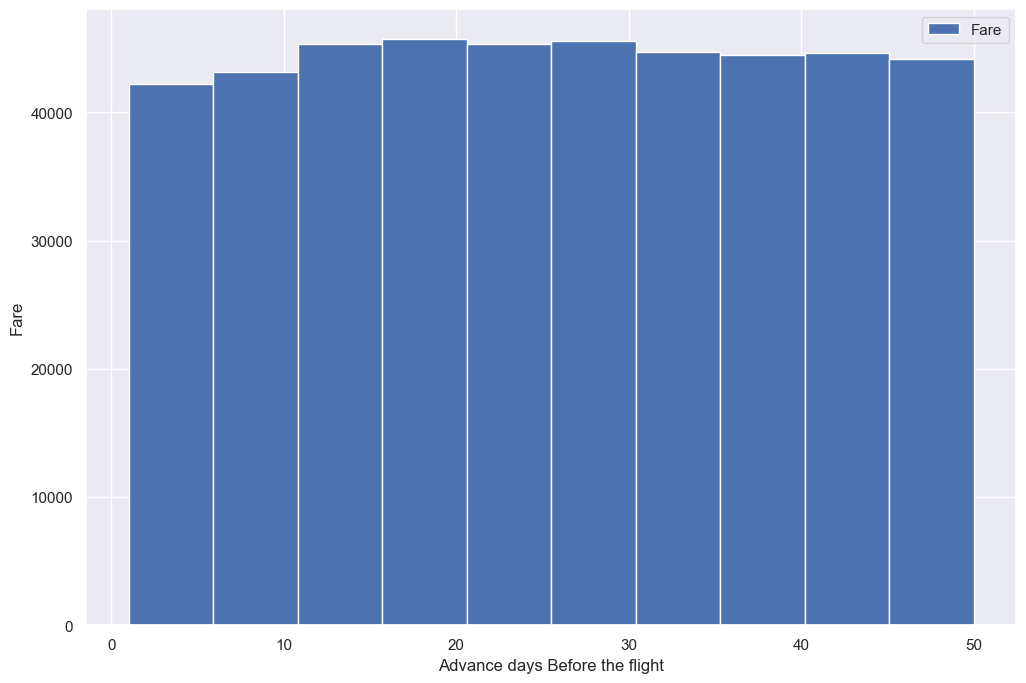

In [442]:
dtf.Advance_days.hist(label = "Fare")

# Add labels to the x and y axes
plt.xlabel('Advance days Before the flight')
plt.ylabel('Fare')
plt.legend()

# Show the plot
plt.show()

We can see that there is no significant meaning for booking the flight in advance.

We will examine the destinations, analyzing the flight frequencies for each part of the day

In [443]:
data = dtf.groupby("Destination")["Arrival"].value_counts()
data.head(28)

Destination  Arrival      
Ahmedabad    night            20133
             morning          12197
             noon              9773
             Early morning      927
Bangalore    night            32875
             morning          21241
             noon             12845
             Early morning     4642
Chennai      night            26399
             morning          16590
             noon             10751
             Early morning     3320
Delhi        night            29925
             noon             21786
             morning          16890
             Early morning     8157
Hyderabad    night            24154
             noon             17376
             morning          15319
             Early morning     4926
Kolkata      night            26829
             morning          16127
             noon              8356
             Early morning     2153
Mumbai       night            36657
             noon             19435
             morning          19301
 

Now, let's examine a Violin plot showcasing the fare distribution for each class

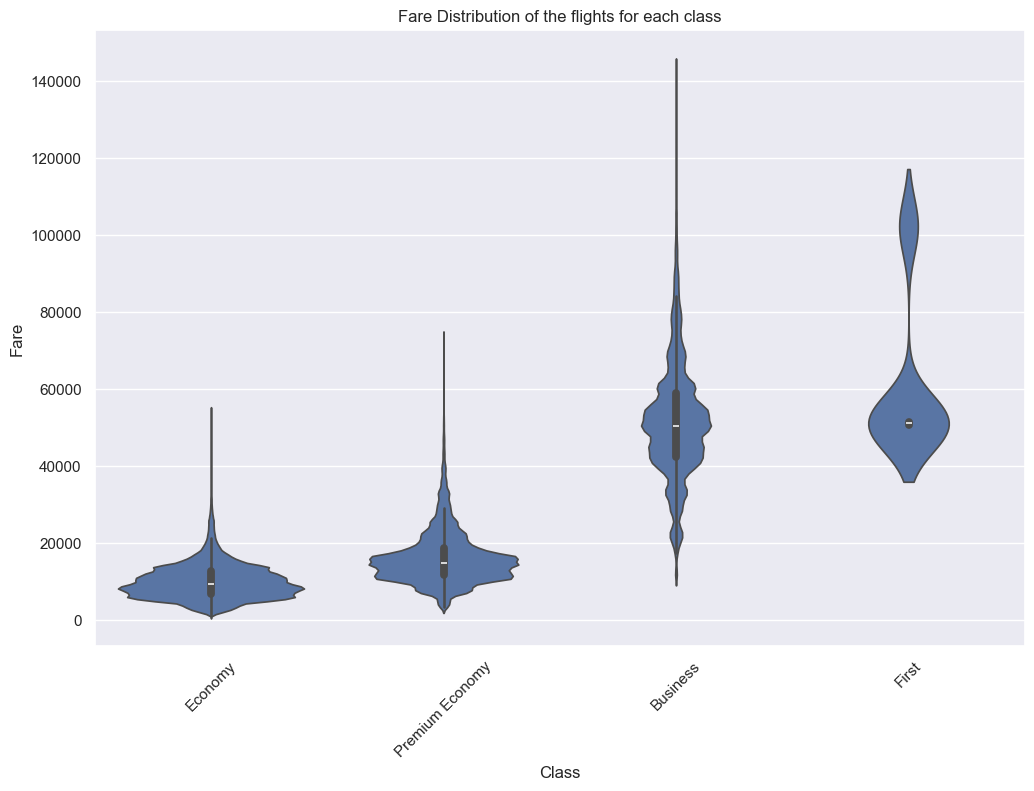

In [444]:
# Create the violin plot
plt.figure(figsize=(12, 8))
sns.violinplot(x='Class', y='Fare', data=dtf)
plt.title('Fare Distribution of the flights for each class')
plt.xlabel('Class')
plt.ylabel('Fare')
plt.xticks(rotation=45)
plt.show()

Using the Violin plot, we can gain insights into the distribution of flight fares across different class types:
- Economy class has an average fare of 10,000 INR, with the majority of listings falling between 5,000 INR and 15,000 INR.
- Premium Economy class has an average fare of 15,000 INR, with the majority of listings ranging from 10,000 INR to 20,000 INR.
- Business class has an average fare of 50,000 INR, with most listings falling between 40,000 INR and 60,000 INR.
- First class has an average fare of 50,000 INR, with the majority of listings between 45,000 INR and 55,000 INR. Additionally, there is another peak around 100,000 INR.
  
It's evident that Business and First class tickets are more expensive compared to Economy and Premium Economy, as expected.

### Examining Correlations to the target feature

<Axes: >

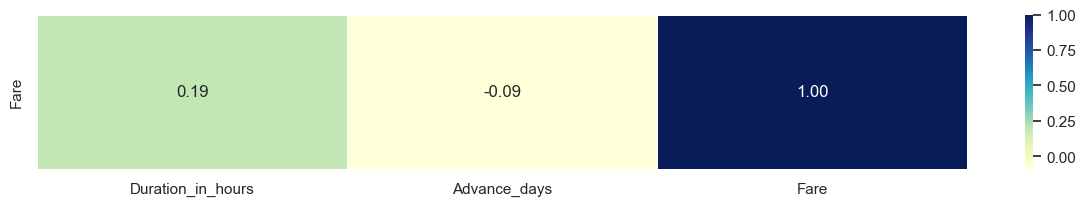

In [445]:
numeric_columns = dtf.dtypes[(dtf.dtypes=="float64") | (dtf.dtypes=="int64")].index.tolist()
numeric_columns = dtf[numeric_columns]
dtf_corr = numeric_columns.corr(method="pearson").loc[["Fare"]]
fig, ax = plt.subplots(figsize=(15,2))

sns.heatmap(dtf_corr, annot=True, fmt='.2f', cmap="YlGnBu", cbar=True, linewidths=0.5,ax=ax)

Weak correlations were observed between fare and flight duration (0.19) as well as advance ticket purchase days (-0.09), suggesting slight trends but not conclusive associations.

In [446]:
# Create a copy of the original DataFrame to preserve original attributes
original_dtf = dtf.copy()
print(original_dtf)

       Date_of_journey Journey_day    Airline Flight_code     Class  \
0           2023-01-16      Monday   SpiceJet     SG-8169   Economy   
1           2023-01-16      Monday     Indigo     6E-2519   Economy   
2           2023-01-16      Monday   GO FIRST      G8-354   Economy   
3           2023-01-16      Monday   SpiceJet     SG-8709   Economy   
4           2023-01-16      Monday  Air India      AI-805   Economy   
...                ...         ...        ...         ...       ...   
452081      2023-03-06      Monday    Vistara      UK-918  Business   
452082      2023-03-06      Monday    Vistara      UK-946  Business   
452083      2023-03-06      Monday    Vistara      UK-926  Business   
452084      2023-03-06      Monday    Vistara      UK-918  Business   
452086      2023-03-06      Monday    Vistara      UK-946  Business   

           Source      Departure Total_stops        Arrival Destination  \
0           Delhi          night    non-stop          night      Mumbai 

### Converting categorial attributes to numeric values

In [447]:
dtf['Date_of_journey'] = pd.to_datetime(dtf['Date_of_journey'])  # Convert to datetime if not already

# Find the minimum date in the column as a reference point
min_date = dtf['Date_of_journey'].min()

# Convert the dates to numeric values representing elapsed time in days
dtf['Date_of_journey_numeric'] = (dtf['Date_of_journey'] - min_date).dt.total_seconds() / (24 * 60 * 60)  # Convert seconds to days

In [448]:
day_mapping = {
    'Sunday': 1,
    'Monday': 2,
    'Tuesday': 3,
    'Wednesday': 4,
    'Thursday': 5,
    'Friday': 6,
    'Saturday': 7
}

# Map the days of the week to numeric values
dtf['Journey_day_numeric'] = dtf['Journey_day'].map(day_mapping)


In [449]:
class_mapping = {
    'Economy': 1,
    'Premium Economy': 2,
    'Business': 3,
    'First': 4
}

# Map the class to numeric values
dtf['Class'] = dtf['Class'].map(class_mapping)

In [450]:
stop_mapping = {
    'non-stop': 0,
    '1-stop': 1,
    '2+-stop': 2
}

# Map the total stops to numeric values
dtf['Total_stops'] = dtf['Total_stops'].map(stop_mapping)

**Date_of_journey ----> Date_of_journey_numeric**  
Our data is between 16/01/2023 and 06/03/2023 therefore we converted the dates in the following format:  
16/01/2023 ----> 0  
17/01/2023 ----> 1  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;.  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;.  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;.  
06/03/2023 ----> 49  

**Journey_day ----> Date_of_journey_numeric**  
'Sunday' ----> 1  
'Monday' ----> 2  
'Tuesday' ----> 3  
'Wednesday' ----> 4  
'Thursday' ----> 5  
'Friday' ----> 6  
'Saturday' ----> 7  


Converting all the other categorial attributes by a LabelEncoder function

In [451]:
from sklearn.preprocessing import LabelEncoder
# Encode categorical variables
label_encoder = LabelEncoder()
for col in ['Airline', 'Flight_code', 'Source', 'Departure', 'Arrival', 'Destination']:
    dtf[col] = label_encoder.fit_transform(dtf[col])

# Drop original datetime columns
dtf.drop(columns=['Date_of_journey', 'Journey_day'], inplace=True)

print(dtf)


        Airline  Flight_code  Class  Source  Departure  Total_stops  Arrival  \
0             6         1209      1       3          2            0        2   
1             5          164      1       3          2            0        0   
2             4          942      1       3          2            0        0   
3             6         1224      1       3          2            0        2   
4             0          852      1       3          2            0        2   
...         ...          ...    ...     ...        ...          ...      ...   
452081        8         1358      3       0          0            1        3   
452082        8         1374      3       0          1            1        2   
452083        8         1360      3       0          1            1        2   
452084        8         1358      3       0          0            1        3   
452086        8         1374      3       0          1            1        2   

        Destination  Duration_in_hours 

<Axes: >

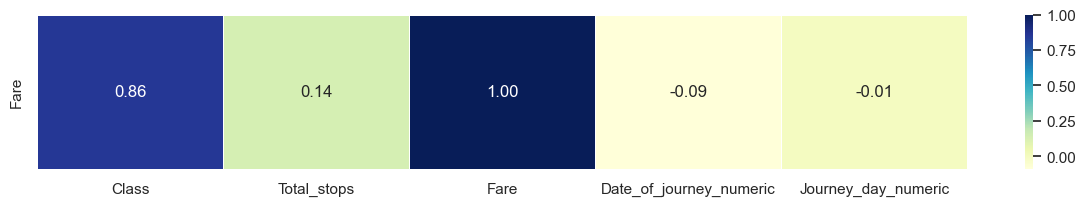

In [452]:
columns_checked = ["Duration_in_hours","Advance_days"]
columns = dtf.dtypes[(dtf.dtypes=="float64") | (dtf.dtypes=="int64")].index.tolist()
columns = [c for c in columns if c not in columns_checked]
columns = dtf[columns]
dtf_corr = columns.corr(method="pearson").loc[["Fare"]]
fig, ax = plt.subplots(figsize=(15,2))

sns.heatmap(dtf_corr, annot=True, fmt='.2f', cmap="YlGnBu", cbar=True, linewidths=0.5,ax=ax)

We didn't observe any significant correlation between the flight Fare and the other attributes.

## Baseline Model

In [453]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import r2_score,mean_squared_error, mean_absolute_percentage_error,mean_absolute_error

In [509]:
# We will split the dataset into features and target variables. The target variable is the fare, and all the others are the features.
# Our predictors
X = dtf.drop(columns = 'Fare')

# Our outcome variable
y = dtf.Fare

We will split the data to test and training sets with stratified method based on the daily variation of flights with shaffle before split.

In [510]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, stratify=dtf["Journey_day_numeric"], random_state=42, shuffle = True)

In [511]:
# Train XGBoost as a baseline model for our pipeline
baseline_model = xgb.XGBRegressor(objective="reg:squarederror")
baseline_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [512]:
y_pred = baseline_model.predict(X_test)
print("R2 Score:", r2_score(y_test, y_pred))

R2 Score: 0.949394285990552


A R-squared (R²) score of 0.9489 indicates that approximately 94.97% of the variance in the dependent variable (target variable) is explained by the independent variables (predictors) in your regression model.

In [458]:
print("Mean Absolute Perc Error:","{:,.3f}".format(mean_absolute_percentage_error(y_test,y_pred)))
print("Mean Absolute Error:", "{:,.0f}".format(mean_absolute_error(y_test, y_pred)))
print("Root Mean Squared Error:", "{:,.0f}".format(np.sqrt(mean_squared_error(y_test, y_pred))))

## residuals
residuals = y_test - y_pred
max_error = residuals.abs().max()
max_idx = residuals[residuals==max_error].index[0]
#max_true, max_pred = y_test.loc[max_idx], prediction[max_idx]
print("Max Error:", "{:,.0f}".format(max_error))

Mean Absolute Perc Error: 0.141
Mean Absolute Error: 2,697
Root Mean Squared Error: 4,608
Max Error: 49,397


We now plot the true values against the predicted values.

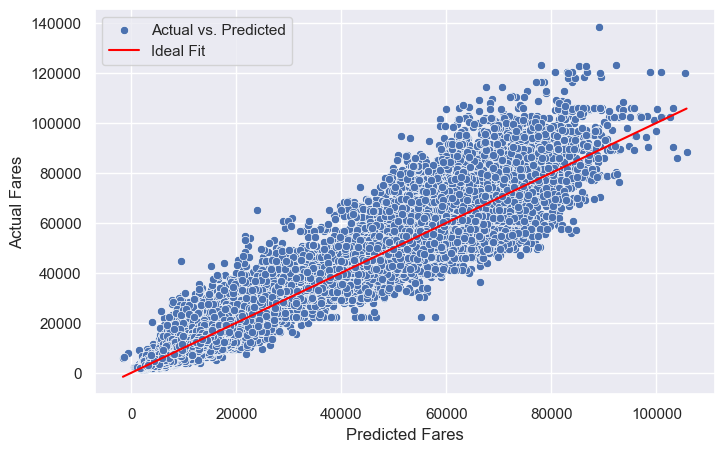

In [459]:
# print the predicted fares regression plot
fig, ax = plt.subplots(figsize=(8,5))
sns.scatterplot(x=y_pred,y=y_test,ax=ax, label='Actual vs. Predicted')
sns.lineplot(x=y_pred,y=y_pred,ax=ax,color='red', label='Ideal Fit')
ax.set_xlabel('Predicted Fares')
ax.set_ylabel('Actual Fares')
ax.legend()
plt.show()

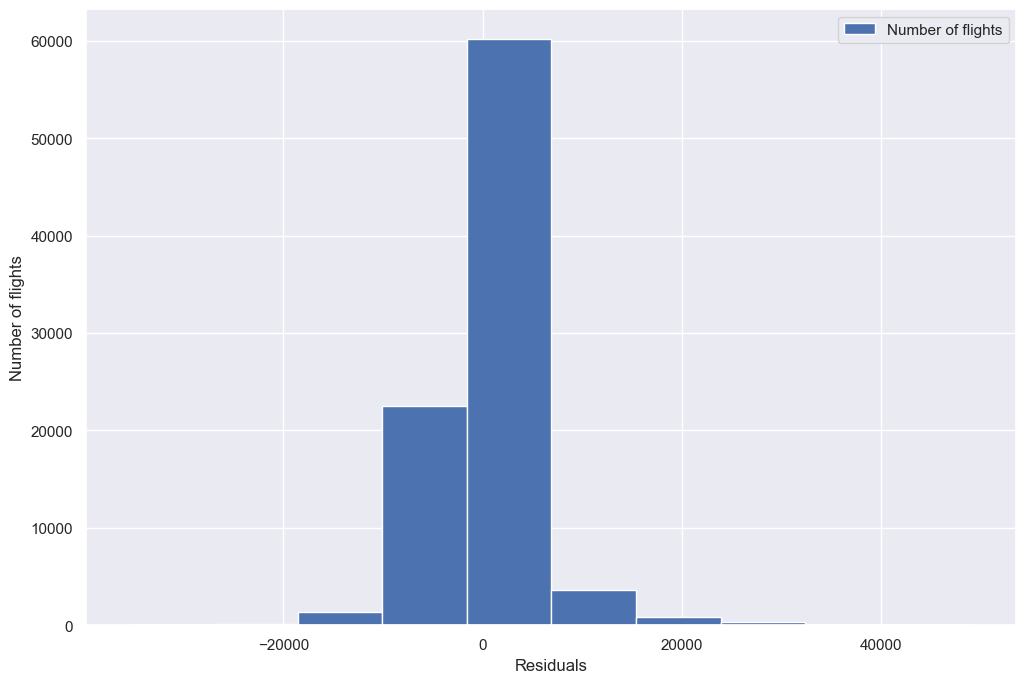

In [460]:
residuals.hist(label = 'Number of flights')
# Add labels to the x and y axes
plt.xlabel('Residuals')
plt.ylabel('Number of flights')
plt.legend()

# Show the plot
plt.show()

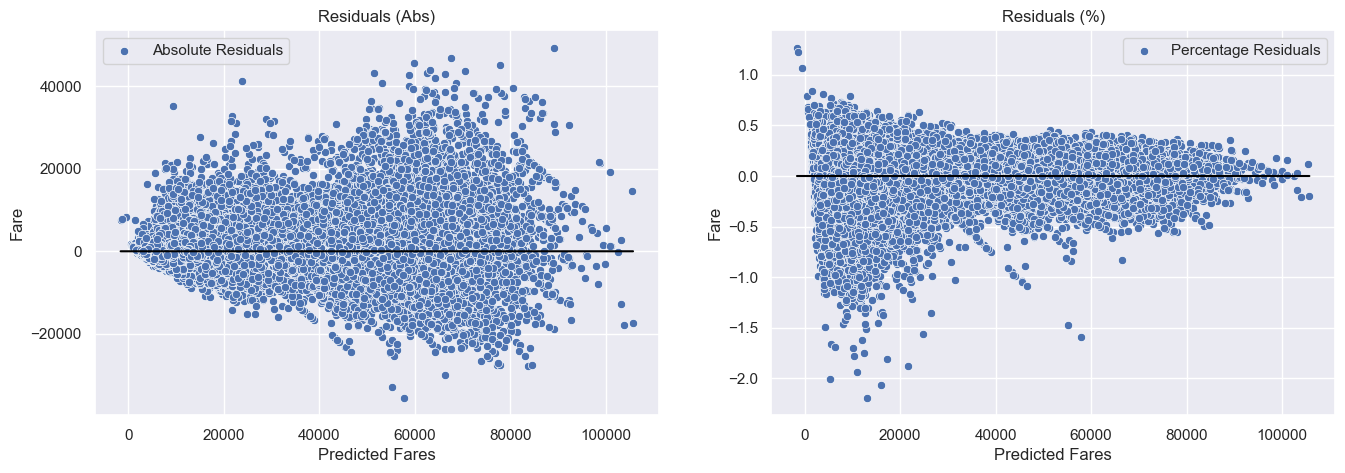

In [461]:
# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

# Scatter plot for absolute residuals
sns.scatterplot(x=y_pred, y=residuals, ax=ax[0], label='Absolute Residuals')
sns.lineplot(x=y_pred, y=0, ax=ax[0], color='black')
ax[0].set_title("Residuals (Abs)")
ax[0].legend()  # Add legend
ax[0].set_xlabel('Predicted Fares')  # Add x-axis label

# Scatter plot for percentage residuals
sns.scatterplot(x=y_pred, y=residuals/y_test, ax=ax[1], label='Percentage Residuals')
sns.lineplot(x=y_pred, y=0, ax=ax[1], color='black')
ax[1].set_title("Residuals (%)")
ax[1].legend()  # Add legend
ax[1].set_xlabel('Predicted Fares')  # Add x-axis label

plt.show()

We can see that we have some big mistakes and some small mistakes

In [462]:
rel_res=residuals/y_test
rel_res=rel_res.abs()

How many time did our model achieve low estimation error (error less than 5%)?

In [463]:
len(rel_res[rel_res<0.05])/len(rel_res)

0.2924646922783304

How many time did our model achieve low estimation error (error more than 20%)?:

In [464]:
len(rel_res[rel_res>0.2])/len(rel_res)

0.23551204616386376

## Results

The baseline model has a Mean Absolute Error of 2,663 and an R2 score of ~0.9489, which looks almost like a perfect fit for our model.  
The regression plot shows that the predicted fares are close to the actual fares, and the residuals distribution plot shows that the residuals are normally distributed around 0.
We can see that in the residuals histogram most of the residuals are around 0, which means the prediction is pretty accurate.
we can see that there are more low estimators than high.

In [465]:
 ## ------------------------------------ PART 3  ------------------------------------

Now, we would like to analyze the predictions using the SHAP library, a tool commonly used for interpreting machine learning models. Therefore, we'll sample the top overpredicted and underpredicted instances. By doing so, we aim to discern patterns and underlying factors contributing to these predicted outliers.

In [513]:

# Calculate the difference between predicted and actual fares
fare_difference = y_pred - y_test

# Sorting the fare differences
sorted_fare_difference = fare_difference.sort_values(ascending=False)

# Get the indices of top 1000 over-predicted and under-predicted samples
top_1000_over_predicted_indices = sorted_fare_difference.index[:1000]
top_1000_under_predicted_indices = sorted_fare_difference.index[-1000:]

# Extract the corresponding samples from the dataset
top_1000_over_predicted_samples = dtf.loc[top_1000_over_predicted_indices].drop(columns=['Fare'])
top_1000_under_predicted_samples = dtf.loc[top_1000_under_predicted_indices].drop(columns=['Fare'])


# Print the top 1000 over-predicted and under-predicted samples
print("Top 1000 Over-predicted Samples:")
print(top_1000_over_predicted_samples)
print("\nTop 1000 Under-predicted Samples:")
print(top_1000_under_predicted_samples)

# Extract the corresponding samples from the dataset
top_1000_over_predicted_samples_original = original_dtf.loc[top_1000_over_predicted_indices]
top_1000_under_predicted_samples_original = original_dtf.loc[top_1000_under_predicted_indices]

# Print the top 1000 over-predicted and under-predicted samples
print("Top 1000 Over-predicted Samples original:")
print(top_1000_over_predicted_samples_original)
print("\nTop 1000 Under-predicted Samples original:")
print(top_1000_under_predicted_samples_original)

Top 1000 Over-predicted Samples:
        Airline  Flight_code  Class  Source  Departure  Total_stops  Arrival  \
101734        8         1329      3       6          1            1        3   
1040          8         1387      3       3          2            1        1   
272306        8         1335      3       4          2            1        2   
129315        8         1379      3       6          1            1        2   
364285        8         1311      3       2          2            1        3   
...         ...          ...    ...     ...        ...          ...      ...   
347074        8         1275      3       5          3            1        1   
6329          8         1402      3       3          1            0        3   
138026        8         1398      3       6          2            1        1   
77141         8         1252      3       3          3            2        2   
274018        8         1335      3       4          2            1        2   

      

## SHAP analysis

In [514]:
import shap

explainer = shap.TreeExplainer(baseline_model)

# Calculate SHAP values for top over-predicted and under-predicted samples
shap_values_over_predicted = explainer(top_1000_over_predicted_samples)
shap_values_under_predicted = explainer(top_1000_under_predicted_samples)

### Visualize SHAP summary plot for top over-predicted samples

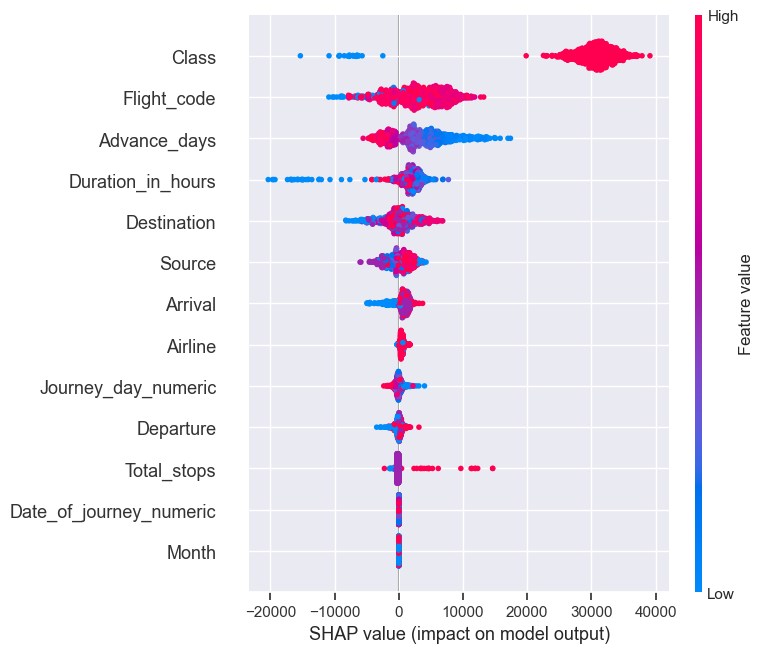

In [515]:
shap.summary_plot(shap_values_over_predicted, features=top_1000_over_predicted_samples, title="SHAP Summary Plot - Top Over-predicted Samples")

### Visualize SHAP summary plot for top under-predicted samples

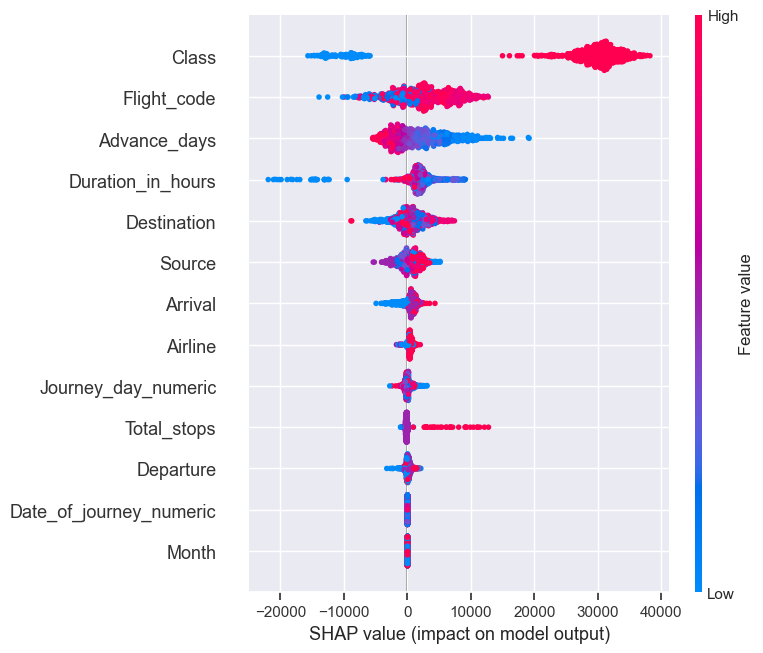

In [516]:
shap.summary_plot(shap_values_under_predicted, features=top_1000_under_predicted_samples, title="SHAP Summary Plot - Top Under-predicted Samples")

Both plots illustrate the effect of the different features on predictions. Samples further away from the zero line indicate a stronger negative or positive effect on price predictions. For instance, in the 'class' feature, "low" blue dots (representing economy class) are associated with lower predicted prices than actual prices, while "high" red dots (representing first class) are associated with higher predicted prices than actual prices.
We can also see that in the 'Advance_days' feature, we observe an inverse relationship: higher values (indicating booking the flight well in advance) correspond to lower predicted prices, and conversely, lower values correspond to higher predicted prices.

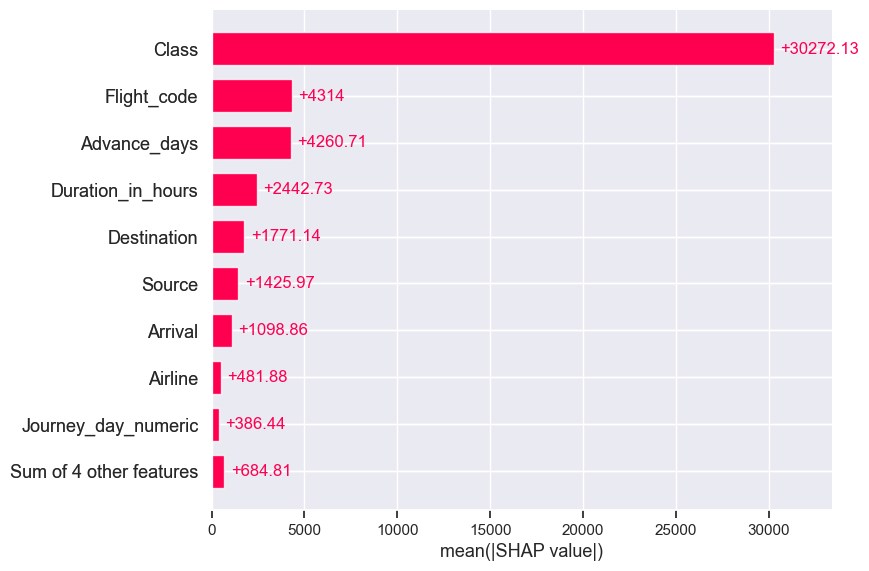

In [517]:
shap.plots.bar(shap_values_over_predicted)

Note: We ran the bar plot also for the underpredicted shap values and got a similar result so we present just the overpredicted plot. 

### SHAP Conclusions

Note: We conducted SHAP analysis on the entire dataset as well, although we didn't include it, in order to reduce  the number of plots.
However, we'll utilize insights from the entire dataset analysis to draw conclusions.
To summarize briefly, the 'class' feature has the most significant influence on the predictions. Additionally, 'duration_in_hours' and 'advance_days' have a similar effects on the predictions, (smaller gaps between them then the ones shown on the above bar plot).
Moreover, there's a difference in the influence of the 'source' feature, where in the above plot a larger effect is shown.

After running SHAP on the overpredicted and underpredicted instances, we got to a few interesting conclusions:
- We can see that the most influence on the over/under predicted instances is the Class feature, but we also noticed that it has the most influence on the predictions of the entire data, so it fits our expectations.
- In the source feature we saw a small difference between the influence of it on the entire data predictions, where in the top 1000 over/under predicted instances we saw it had a larger effect, and it suits our suspicions regarding the amount of occurences of Delhi in our 1000 over/under predicted instances
- In the duration_in_hours feature has influence on the over/under predicted instances. We can see that "low" blue dots (representing shorter flight duration) are associated with lower predicted prices than actual prices, as expected.

 ## binning

In [471]:
# Define bins for advanced_days
bins = [0, 14, 28, float('inf')]
labels = [0, 1, 2]
data= dtf.copy()
# Bin advanced_days
data['Advance_days_bin'] = pd.cut(data['Advance_days'], bins=bins, labels=False, right=True)
data= data.drop(columns=['Advance_days'])
# Convert the bin labels to integers
data['Advance_days_bin'] = data['Advance_days_bin'].astype(int)

In [472]:
#Split the dataset into training and testing sets
X_test['Advance_days']= data['Advance_days_bin']
X_train['Advance_days']= data['Advance_days_bin']

In [473]:
# Train XGBoost as a baseline model for our pipeline
baseline_model_new = xgb.XGBRegressor(objective="reg:squarederror")
baseline_model_new.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [474]:
y_pred = baseline_model_new.predict(X_test)
print("R2 Score:", r2_score(y_test, y_pred))

R2 Score: 0.9489078101228037


## run the model without outliers

In [475]:
# Drop the top 1000 over-predicted and under-predicted instances from the data
dtf = dtf.drop(index=top_1000_over_predicted_indices)
dft = dtf.drop(index=top_1000_under_predicted_indices)

In [476]:
# Split the dataset into training and testing sets
X = dtf.drop(columns = 'Fare')

# Our outcome variable
y = dtf.Fare
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, stratify=dtf["Journey_day_numeric"], random_state=42, shuffle = True)

In [477]:
# Train XGBoost as a baseline model for our pipeline
baseline_model_rm_outliers = xgb.XGBRegressor(objective="reg:squarederror")
baseline_model_rm_outliers.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [478]:
y_pred = baseline_model_new.predict(X_test)
print("R2 Score:", r2_score(y_test, y_pred))

R2 Score: 0.946088121674783


# log 

check the number of accurances of each class in the 1000 over/under predicted samples

In [518]:
# Count the occurrences of each source in the top 1000 over-predicted samples
over_pred_source_counts = top_1000_over_predicted_samples['Class'].value_counts()
under_pred_source_counts = top_1000_under_predicted_samples['Class'].value_counts()

print("Counts of sources in the top 1000 over-predicted samples:")
print(over_pred_source_counts)

print("Counts of sources in the top 1000 under-predicted samples:")
print(under_pred_source_counts)

Counts of sources in the top 1000 over-predicted samples:
Class
3    978
2     21
1      1
Name: count, dtype: int64
Counts of sources in the top 1000 under-predicted samples:
Class
3    885
2     70
1     45
Name: count, dtype: int64


We might want to punish class=3 since it has the largest amount of instances with this value

We want to try to train the model with applying logarithmic function on the target values, and maybe add some hyperparameters to improve the basline model accuracy

In [533]:
#using logarithmic 
y_log = np.cbrt(y)

X_train, X_test, y_train, y_test = train_test_split(X,y_log, test_size=0.2, stratify=dtf["Journey_day_numeric"], random_state=42, shuffle = True)

# Define punishment weights based on class values
class_punishment = {3: 2}  # Punish class 3 more heavily

# Create custom weights for each sample based on its class
sample_weights_train = np.array([class_punishment.get(c, 1) for c in X_train["Class"]])
sample_weights_test = np.array([class_punishment.get(c, 1) for c in X_test["Class"]])

# Define the XGBoost regressor
baseline_model_log_fare_weighted = xgb.XGBRegressor(objective="reg:squarederror")

# Train the model with custom sample weights
baseline_model_log_fare_weighted.fit(X_train, y_train, sample_weight=sample_weights_train)

# The best hyperparameters
best_params = {'learning_rate': 0.2, 'max_depth': 9, 'reg_lambda': 0}

# Train the model with the best hyperparameters
best_model = xgb.XGBRegressor(objective="reg:squarederror", **best_params)
best_model.fit(X_train, y_train, sample_weight=sample_weights_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [534]:
y_pred = best_model.predict(X_test)
print("R2 Score:", r2_score(y_test, y_pred))

R2 Score: 0.971149956242018


In [532]:
print("Mean Absolute Perc Error:","{:,.3f}".format(mean_absolute_percentage_error(y_test,y_pred)))

Mean Absolute Perc Error: 0.035


we will get the 1000 Over/under predicted Samples

In [484]:
# Calculate the difference between predicted and actual fares
fare_difference = y_pred - y_test

# Sorting the fare differences
sorted_fare_difference = fare_difference.sort_values(ascending=False)

# Get the indices of top 1000 over-predicted and under-predicted samples
top_1000_over_predicted_indices = sorted_fare_difference.index[:1000]
top_1000_under_predicted_indices = sorted_fare_difference.index[-1000:]

# Extract the corresponding samples from the dataset
top_1000_over_predicted_samples = dtf.loc[top_1000_over_predicted_indices].drop(columns=['Fare'])
top_1000_under_predicted_samples = dtf.loc[top_1000_under_predicted_indices].drop(columns=['Fare'])

In [485]:
explainer = shap.TreeExplainer(best_model)

# Calculate SHAP values for top over-predicted and under-predicted samples
shap_values_over_predicted = explainer(top_1000_over_predicted_samples)
shap_values_under_predicted = explainer(top_1000_under_predicted_samples)

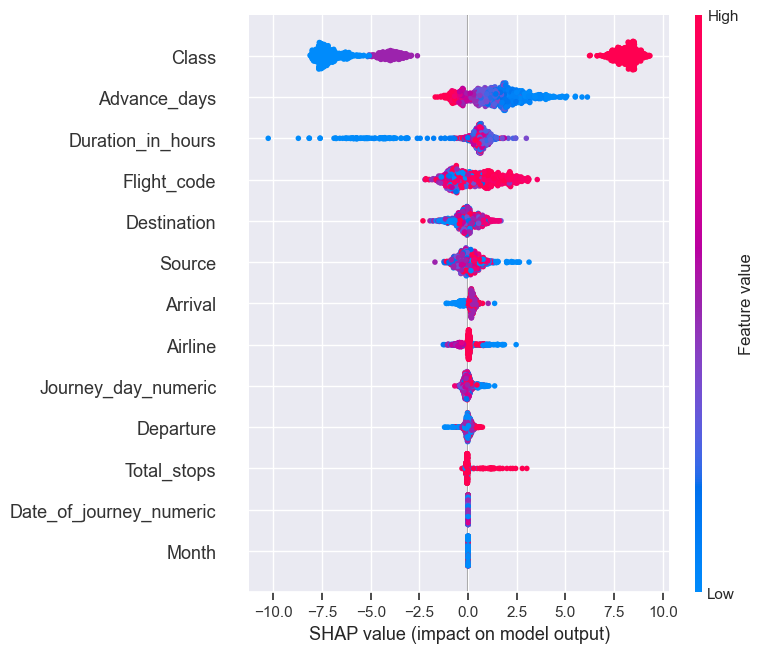

In [486]:
shap.summary_plot(shap_values_over_predicted, features=top_1000_over_predicted_samples, title="SHAP Summary Plot - Top Over-predicted Samples")

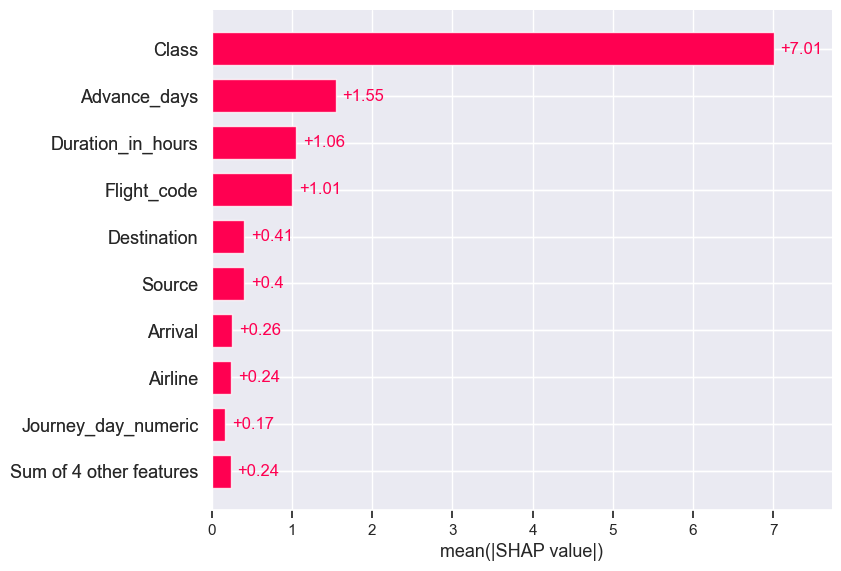

In [487]:
shap.plots.bar(shap_values_over_predicted)

In [488]:
# Count the occurrences of each source in the top 1000 over-predicted samples
over_pred_source_counts = top_1000_over_predicted_samples['Class'].value_counts()
under_pred_source_counts = top_1000_under_predicted_samples['Class'].value_counts()

print("Counts of sources in the top 1000 over-predicted samples:")
print(over_pred_source_counts)

print("Counts of sources in the top 1000 under-predicted samples:")
print(under_pred_source_counts)

Counts of sources in the top 1000 over-predicted samples:
Class
3    431
1    386
2    183
Name: count, dtype: int64
Counts of sources in the top 1000 under-predicted samples:
Class
1    464
3    328
2    208
Name: count, dtype: int64


in the above print we can see that the number of class=3 instances in the over/under predictions is balanced 

# Categorical Embedding

In [489]:
# # Data processing
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
from sklearn import metrics, preprocessing
from tensorflow.keras import layers, utils, callbacks, optimizers
from tensorflow.keras.models import Model, load_model
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.layers import Input, Embedding, Reshape
from tensorflow.keras.layers import Concatenate

# # Train test split
from sklearn.model_selection import train_test_split

# Model
from sklearn.ensemble import RandomForestRegressor

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize neural network model structure
from keras.utils import plot_model
from IPython.display import Image

# Deep learning model
from tensorflow.keras.layers import Input, Dense, Reshape, Concatenate, Embedding, SpatialDropout1D
from tensorflow.keras.models import Model, load_model
from keras.callbacks import EarlyStopping

In [490]:
original_dtf_copy = original_dtf.copy()

min_date = original_dtf_copy['Date_of_journey'].min()
original_dtf_copy['Date_of_journey'] = (original_dtf_copy['Date_of_journey'] - min_date).dt.total_seconds() / (24 * 60 * 60)  # Convert seconds to days

numeric_features = ['Duration_in_hours','Advance_days','Date_of_journey', 'Fare']
categorical_features = [f for f in original_dtf.columns if f not in numeric_features]

features = [feature for feature in numeric_features + categorical_features if feature != 'Fare']
print(features)

le_dict= {}
for col in categorical_features:
    le= preprocessing.LabelEncoder()
    original_dtf_copy[col] = le.fit_transform(original_dtf_copy[col])
    #later on for mapping purposes
    le_dict[col] = dict(zip(le.classes_, le.transform(le.classes_)))
le_dict

['Duration_in_hours', 'Advance_days', 'Date_of_journey', 'Journey_day', 'Airline', 'Flight_code', 'Class', 'Source', 'Departure', 'Total_stops', 'Arrival', 'Destination', 'Month']


{'Journey_day': {'Friday': 0,
  'Monday': 1,
  'Saturday': 2,
  'Sunday': 3,
  'Thursday': 4,
  'Tuesday': 5,
  'Wednesday': 6},
 'Airline': {'Air India': 0,
  'AirAsia': 1,
  'AkasaAir': 2,
  'AllianceAir': 3,
  'GO FIRST': 4,
  'Indigo': 5,
  'SpiceJet': 6,
  'StarAir': 7,
  'Vistara': 8},
 'Flight_code': {'6E-107': 0,
  '6E-108': 1,
  '6E-109': 2,
  '6E-113': 3,
  '6E-114': 4,
  '6E-116': 5,
  '6E-117': 6,
  '6E-123': 7,
  '6E-124': 8,
  '6E-125': 9,
  '6E-128': 10,
  '6E-133': 11,
  '6E-134': 12,
  '6E-135': 13,
  '6E-136': 14,
  '6E-138': 15,
  '6E-139': 16,
  '6E-149': 17,
  '6E-151': 18,
  '6E-153': 19,
  '6E-154': 20,
  '6E-156': 21,
  '6E-157': 22,
  '6E-158': 23,
  '6E-163': 24,
  '6E-165': 25,
  '6E-172': 26,
  '6E-176': 27,
  '6E-179': 28,
  '6E-182': 29,
  '6E-183': 30,
  '6E-184': 31,
  '6E-188': 32,
  '6E-189': 33,
  '6E-192': 34,
  '6E-193': 35,
  '6E-194': 36,
  '6E-195': 37,
  '6E-196': 38,
  '6E-2002': 39,
  '6E-2004': 40,
  '6E-2005': 41,
  '6E-2007': 42,
  '6E-2009

In [491]:
input_dtf_list = []

nf_without_fare = [feature for feature in numeric_features if feature != 'Fare']
for x in list(categorical_features):
    input_dtf_list.append(original_dtf_copy[x].values)

input_dtf_list.append(original_dtf_copy[nf_without_fare].values)

target = original_dtf_copy['Fare'].values
input_dtf_list

[array([1, 1, 1, ..., 1, 1, 1]),
 array([6, 5, 4, ..., 8, 8, 8]),
 array([1209,  164,  942, ..., 1360, 1358, 1374]),
 array([1, 1, 1, ..., 0, 0, 0]),
 array([3, 3, 3, ..., 0, 0, 0]),
 array([2, 2, 2, ..., 1, 0, 1]),
 array([2, 2, 2, ..., 0, 0, 0]),
 array([2, 0, 0, ..., 2, 3, 2]),
 array([6, 6, 6, ..., 2, 2, 2]),
 array([0, 0, 0, ..., 2, 2, 2], dtype=int64),
 array([[ 2.0833,  1.    ,  0.    ],
        [ 2.3333,  1.    ,  0.    ],
        [ 2.1667,  1.    ,  0.    ],
        ...,
        [13.0833, 50.    , 49.    ],
        [11.25  , 50.    , 49.    ],
        [11.1667, 50.    , 49.    ]])]

In [492]:
input_models = []

output_embeddings = []

for x in categorical_features:
    cat_embed_name = x + '_embedding'
    no_of_unique_cat = original_dtf_copy[x].nunique()
    embedding_size = int(min(np.ceil((no_of_unique_cat)/2), 50))
    input_model = Input(shape=(1,), name = x + '_input')
    embed = Embedding(input_dim = no_of_unique_cat+1,output_dim = embedding_size, name = cat_embed_name)(input_model)
    embed = SpatialDropout1D(0.3)(embed)
    output_model = Reshape(target_shape = (embedding_size,))(embed)
    input_models.append(input_model)
    output_embeddings.append(output_model)

In [493]:
input_numeric = [Input(shape=(len(nf_without_fare),))]

embed_layer = Concatenate()([*output_embeddings,*input_numeric])
x = layers.BatchNormalization()(embed_layer)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.3)(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(64, activation="relu")(x)
#x = layers.Dropout(0.3)(x)
x = layers.BatchNormalization()(x)
output = layers.Dense(1, activation="linear")(x)


In [494]:
def auc(y_true, y_pred):
    def fallback_auc(y_true, y_pred):
        try:
            return metrics.roc_auc_score(y_true, y_pred)
        except:
            return 0.5
    return tf.py_function(fallback_auc, (y_true, y_pred), tf.double)

In [495]:
#model = Model(inputs = input_models,outputs = output)
model = Model(inputs=[*input_models,*input_numeric], outputs=output)
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])


In [496]:
model.summary()

Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Journey_day_input             │ (None, 1)                 │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Airline_input (InputLayer)    │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Flight_code_input             │ (None, 1)                 │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Class_input (InputLayer)      │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Source_input (InputLayer)     │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Departure_input (InputLayer)  │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Total_stops_input             │ (None, 1)                 │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Arrival_input (InputLayer)    │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Destination_input             │ (None, 1)                 │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Month_input (InputLayer)      │ (None, 1)                 │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Journey_day_embedding         │ (None, 1, 4)              │              32 │ Journey_day_input[0][0]    │
│ (Embedding)                   │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Airline_embedding (Embedding) │ (None, 1, 5)              │              50 │ Airline_input[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Flight_code_embedding         │ (None, 1, 50)             │          70,300 │ Flight_code_input[0][0]    │
│ (Embedding)                   │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Class_embedding (Embedding)   │ (None, 1, 2)              │              10 │ Class_input[0][0]          │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 90,269 (352.61 KB)

 Trainable params: 89,725 (350.49 KB)

 Non-trainable params: 544 (2.12 KB)

In [497]:
es = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=7,
                                 verbose=1, mode='max', baseline=None, restore_best_weights=True)
rlr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                      patience=5, min_lr=1e-6, mode='max', verbose=1)
history  =  model.fit(input_dtf_list, target, validation_split=0.2, epochs =  200, batch_size = 64, callbacks=[es, rlr], verbose= 1,shuffle=True)

Epoch 1/200
5568/5568 ━━━━━━━━━━━━━━━━━━━━ 28s 4ms/step - loss: 911486848.0000 - mae: 22521.4863 - val_loss: 662909888.0000 - val_mae: 19790.7188 - learning_rate: 0.0010
Epoch 2/200
5568/5568 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - loss: 579672256.0000 - mae: 18044.6016 - val_loss: 299116672.0000 - val_mae: 12976.3457 - learning_rate: 0.0010
Epoch 3/200
5568/5568 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - loss: 207878976.0000 - mae: 10546.2129 - val_loss: 92986480.0000 - val_mae: 6354.9155 - learning_rate: 0.0010
Epoch 4/200
5568/5568 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - loss: 74004512.0000 - mae: 5343.5283 - val_loss: 63303428.0000 - val_mae: 5307.2900 - learning_rate: 0.0010
Epoch 5/200
5568/5568 ━━━━━━━━━━━━━━━━━━━━ 26s 5ms/step - loss: 66322680.0000 - mae: 4890.3774 - val_loss: 64741580.0000 - val_mae: 5390.5762 - learning_rate: 0.0010
Epoch 6/200
5567/5568 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 65619604.0000 - mae: 4887.7129
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00050000002

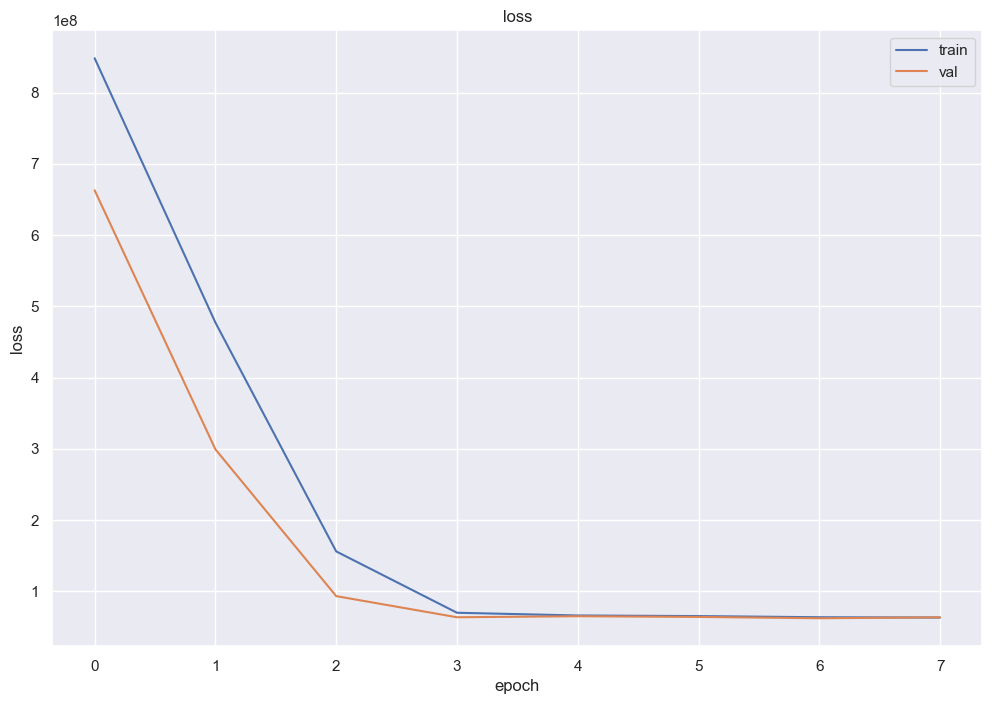

In [498]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

### Converting the values into dataframe and attaching them to the dataframe

In [499]:
# Initialize an empty dictionary to store DataFrames for each categorical column
embeddings_dfs = {}
 
for column in categorical_features:
    indices = le_dict[column]
    
    # Extract embeddings for the current column using the model
    embeddings = {ind: model.get_layer(f'{column}_embedding').get_weights()[0][ind] for _, ind in indices.items()}
    
    # Convert the embeddings dictionary to a DataFrame
    embeddings_df = pd.DataFrame(embeddings).T.reset_index()
    embeddings_df = embeddings_df.rename(columns={'index': f'index_{column}'})
    embeddings_df.columns = [f'{column}_{i}' if i != f'index_{column}' else i for i in embeddings_df.columns]
    embeddings_dfs[column] = embeddings_df
    
# An example for the feature representaion in the Dataframe   
source_df =  embeddings_dfs['Source']
source_df

,index_Source,Source_0,Source_1,Source_2,Source_3
0,0,0.043165,-0.045869,0.045843,-0.025521
1,1,0.058484,0.018228,-0.003849,-0.064383
2,2,-0.109779,0.028596,0.066148,0.062550
3,3,-0.061511,0.069123,0.030850,0.073913
4,4,0.015977,0.022890,0.002568,0.001370
5,5,0.060366,0.018677,-0.053980,-0.069516
6,6,-0.009324,-0.060327,-0.039873,-0.029766


In [500]:
#convert the categorial values by the le_dict - first encoding
original_dtf_c = original_dtf.copy()
for col in categorical_features:
    original_dtf_c[col] = original_dtf_c[col].map(le_dict[col])
original_dtf_c['Date_of_journey'] = (original_dtf_c['Date_of_journey'] - min_date).dt.total_seconds() / (24 * 60 * 60)  # Convert seconds to days

In [501]:
merged_dtf = original_dtf_c.copy()
 
for column in categorical_features:
    embeddings_df = embeddings_dfs[column]
    # Merge the embeddings DataFrame with the original DataFrame
    merged_dtf = pd.merge(merged_dtf, embeddings_df, how='inner', left_on=column, right_on=f'index_{column}')
    merged_dtf.drop([column, f'index_{column}'], axis=1, inplace=True)
    
# The final DataFrame 
merged_dtf

,Date_of_journey,Duration_in_hours,Advance_days,Fare,Journey_day_0,Journey_day_1,Journey_day_2,Journey_day_3,Airline_0,Airline_1,...,Total_stops_0,Total_stops_1,Arrival_0,Arrival_1,Destination_0,Destination_1,Destination_2,Destination_3,Month_0,Month_1
0,0.0,2.0833,1,5335,0.079789,-0.042944,-0.006981,0.025934,0.320975,-0.256319,...,-0.367510,-0.357846,-0.023786,-0.023284,0.029498,-0.051055,-0.063788,0.045636,-0.020668,0.018949
1,0.0,2.3333,1,5899,0.079789,-0.042944,-0.006981,0.025934,0.274777,-0.265899,...,-0.367510,-0.357846,0.065466,0.013249,0.029498,-0.051055,-0.063788,0.045636,-0.020668,0.018949
2,0.0,2.1667,1,5801,0.079789,-0.042944,-0.006981,0.025934,0.313844,-0.275121,...,-0.367510,-0.357846,0.065466,0.013249,0.029498,-0.051055,-0.063788,0.045636,-0.020668,0.018949
3,0.0,2.0833,1,5794,0.079789,-0.042944,-0.006981,0.025934,0.320975,-0.256319,...,-0.367510,-0.357846,-0.023786,-0.023284,0.029498,-0.051055,-0.063788,0.045636,-0.020668,0.018949
4,0.0,2.1667,1,5955,0.079789,-0.042944,-0.006981,0.025934,0.017399,-0.054986,...,-0.367510,-0.357846,-0.023786,-0.023284,0.029498,-0.051055,-0.063788,0.045636,-0.020668,0.018949
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445361,49.0,11.2500,50,61302,0.079789,-0.042944,-0.006981,0.025934,-0.024275,0.024333,...,0.000573,0.002809,-0.036997,-0.014414,0.004695,0.024588,0.063307,-0.003583,0.006844,0.019917
445362,49.0,11.1667,50,65028,0.079789,-0.042944,-0.006981,0.025934,-0.024275,0.024333,...,0.000573,0.002809,-0.023786,-0.023284,0.004695,0.024588,0.063307,-0.003583,0.006844,0.019917
445363,49.0,13.0833,50,65028,0.079789,-0.042944,-0.006981,0.025934,-0.024275,0.024333,...,0.000573,0.002809,-0.023786,-0.023284,0.004695,0.024588,0.063307,-0.003583,0.006844,0.019917
445364,49.0,11.2500,50,69254,0.079789,-0.042944,-0.006981,0.025934,-0.024275,0.024333,...,0.000573,0.002809,-0.036997,-0.014414,0.004695,0.024588,0.063307,-0.003583,0.006844,0.019917


### run the baseline model with the new data

In [502]:
# Split the dataset into training and testing sets
# Our predictors
X = merged_dtf.drop(columns = 'Fare')
y = merged_dtf.Fare
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42, shuffle = True)

In [503]:
# Train XGBoost as a baseline model for our pipeline
baseline_model = xgb.XGBRegressor(objective="reg:squarederror")
baseline_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [504]:
y_pred = baseline_model.predict(X_test)
print("R2 Score:", r2_score(y_test, y_pred))

R2 Score: 0.9529186779417298


We can see that the categorical embedding improved the basline model accuracy , now we will run the best model with this dataFrame and see the accuracy result

In [505]:
y_log = np.cbrt(y)
X_train, X_test, y_train, y_test = train_test_split(X,y_log, test_size=0.2, random_state=42, shuffle = True)

# The best hyperparameters
best_params = {'learning_rate': 0.2, 'max_depth': 9, 'reg_lambda': 0}

# Train the model with the best hyperparameters
best_model = xgb.XGBRegressor(objective="reg:squarederror", **best_params)
best_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [506]:
y_pred = best_model.predict(X_test)
print("R2 Score:", r2_score(y_test, y_pred))

R2 Score: 0.9739003877160572


We can see an improve from the best model without the categorical embedding